In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [11]:
# Use Inspector to print the column names and types
columns = inspector.get_columns('Measurement')
for c in columns:
    print(c['name'], c["type"])
    
columns = inspector.get_columns('Station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

In [12]:
### PRECIPITATION ANALYSIS ###

# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database

session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23')

In [13]:
oneyear_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print("1 Year Ago: ", oneyear_date)

1 Year Ago:  2016-08-23


In [14]:
# Perform a query to retrieve the data and precipitation scores

results = engine.execute("SELECT date, prcp FROM Measurement WHERE date BETWEEN '2016-08-23' AND '2017-08-23'").fetchall()


In [15]:
# Save the query results as a Pandas DataFrame and set the index to the date column

precipitation_df = pd.DataFrame(results, columns=['date', 'precipitation'])
precipitation_df.set_index('date', inplace=True, )
precipitation_df.head()

,precipitation
date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00


In [16]:
# Sort the dataframe by date

precipitation = precipitation_df.sort_values(by='date',ascending=True)
precipitation.head()

,precipitation
date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15


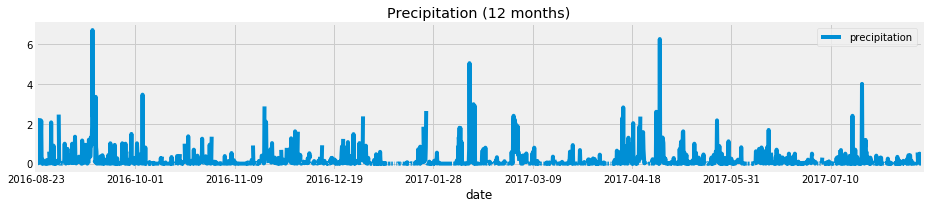

In [17]:
# Use Pandas Plotting with Matplotlib to plot the data

precipitation.plot(figsize=(13,3))

plt.title("Precipitation (12 months)")
plt.legend(loc='best')
plt.savefig("Images_PH/Precipitation.png")
plt.tight_layout()
plt.show()

In [18]:
# Use Pandas to calcualte the summary statistics for the precipitation data

precipitation.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [19]:
### STATION ANALYSIS ###

columns = inspector.get_columns('Station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [20]:
engine.execute("SELECT * FROM Station").fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6),
 (6, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5),
 (7, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9),
 (8, 'USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9),
 (9, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)]

In [21]:
# Design a query to show how many stations are available in this dataset?

stations = session.query(Station.station).count()

print(f'Number of stations available: {stations}')

Number of stations available: 9


In [22]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

active_stations = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

print(f'Most Active Stations')
print(f'********************')
active_stations

Most Active Stations
********************


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [23]:
most_active_station=active_stations[0][0]
print(f"Most Active Station: {most_active_station}")

Most Active Station: USC00519281


In [24]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

most_active_station_lowest_temp = session.query(func.min(Measurement.tobs)).filter(Measurement.station == most_active_station).all()
most_active_station_lowest_temp

most_active_station_highest_temp = session.query(func.max(Measurement.tobs)).filter(Measurement.station == most_active_station).all()
most_active_station_highest_temp

most_active_station_avg_temp = session.query(func.avg(Measurement.tobs)).filter(Measurement.station == most_active_station).all()
most_active_station_avg_temp

print(f'Most Active Station')
print(f'********************')
print(f'Lowest Temperature:  {most_active_station_lowest_temp [0][0]}')
print(f'Highest Temperature:  {most_active_station_highest_temp [0][0]}')
print(f'Average Temperature:  {most_active_station_avg_temp [0][0]}')

Most Active Station
********************
Lowest Temperature:  54.0
Highest Temperature:  85.0
Average Temperature:  71.66378066378067


In [25]:
# Choose the station with the highest number of temperature observations.

station_most_temps = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
station_most_temps = station_most_temps[0]

print(f'Station with Highest Number of Temperature Observation')
print(f'*******************************************************')
print(f'Station:  {station_most_temps [0]}')
print(f'Number of Temparture Observations:  {station_most_temps [1]}')


Station with Highest Number of Temperature Observation
*******************************************************
Station:  USC00519281
Number of Temparture Observations:  2772


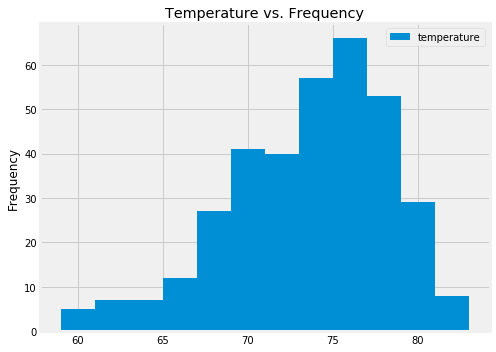

In [26]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

temps = engine.execute("SELECT tobs FROM Measurement WHERE station = 'USC00519281' AND date BETWEEN '2016-08-23' AND '2017-08-23'").fetchall()
temps

temperature_obs = pd.DataFrame(temps, columns=['temperature'])
temperature_obs.head()

temperature_obs.plot.hist(bins=12, figsize=(7,5),title="Temperature vs. Frequency")
plt.tight_layout()
plt.savefig("Images_PH/Temperature_vs_frequency.png")
plt.show()

In [27]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [28]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

mytrip = calc_temps('2017-08-01', '2018-08-15')
mytrip

[(70.0, 78.82417582417582, 85.0)]

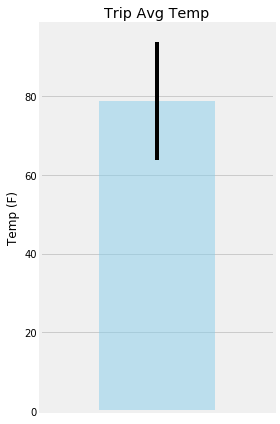

In [29]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

mytrip_temp = pd.DataFrame(mytrip, columns=['tmin', 'tavg', 'tmax'])

mytrip_temp.plot.bar(y='tavg', yerr=(mytrip_temp['tmax'] - mytrip_temp['tmin']), title='Trip Avg Temp', color='skyblue', alpha=0.5, figsize=(4,6))
plt.xticks(np.arange(1, 1.0))
plt.ylabel("Temp (F)")
plt.tight_layout()
plt.gca().legend_.remove()
plt.savefig("Images_PH/TripAvgTemp.png")
plt.show()

In [30]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



## Optional Challenge Assignment

In [31]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [32]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [33]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [34]:
# Plot the daily normals as an area plot with `stacked=False`
